In [21]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.metrics import mean_squared_error
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, Dense, Embedding, Flatten, Concatenate


In [34]:
df = pd.read_csv("exp1.csv",sep=";")

In [35]:
# Criar coluna de data
df['DATA'] = pd.to_datetime(df['ANO'].astype(str) + '-' + df['MÊS'].astype(str) + '-01')

# Agrupar por Unidade, Produto e DATA (somando QTD)
df_agrupado = df.groupby(['Unidade', 'Produto', 'DATA'], as_index=False).agg({'QTD': 'sum'})


In [52]:
def cria_janelas(grupo):
    grupo = grupo.sort_values('DATA')
    for i in range(1, 13):  # Agora vamos criar as janelas para 12 meses
        grupo[f'QTD_t-{i}'] = grupo['QTD'].shift(i)
    return grupo

df_janelas = df_agrupado.groupby(['Unidade', 'Produto']).apply(cria_janelas)
df_janelas = df_janelas.dropna(subset=[f'QTD_t-{i}' for i in range(1, 13)]).reset_index(drop=True)


KeyboardInterrupt: 

In [37]:
le_produto = LabelEncoder()
le_unidade = LabelEncoder()

df_janelas['ProdutoEnc'] = le_produto.fit_transform(df_janelas['Produto'])
df_janelas['UnidadeEnc'] = le_unidade.fit_transform(df_janelas['Unidade'])


In [ ]:
# Normalização
scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()

X_lag_scaled = scaler_X.fit_transform(X_lag)
y_scaled = scaler_y.fit_transform(y.reshape(-1, 1))

# Ajuste para LSTM (12 meses de dados)
X_lag_scaled = X_lag_scaled.reshape((X_lag_scaled.shape[0], 12, 1))  # 12 meses


In [40]:
X_lag_train, X_lag_test, X_prod_train, X_prod_test, X_und_train, X_und_test, y_train, y_test = train_test_split(
    X_lag_scaled, X_prod, X_und, y_scaled, test_size=0.2, random_state=42
)


In [41]:
# Inputs
input_lag = Input(shape=(6, 1))
x = LSTM(64, activation='relu')(input_lag)

input_prod = Input(shape=(1,))
prod_embed = Embedding(input_dim=len(le_produto.classes_), output_dim=5)(input_prod)
prod_flat = Flatten()(prod_embed)

input_und = Input(shape=(1,))
und_embed = Embedding(input_dim=len(le_unidade.classes_), output_dim=5)(input_und)
und_flat = Flatten()(und_embed)

# Combinar tudo
merged = Concatenate()([x, prod_flat, und_flat])
dense = Dense(32, activation='relu')(merged)
output = Dense(1)(dense)

# Modelo final
model = Model(inputs=[input_lag, input_prod, input_und], outputs=output)
model.compile(optimizer='adam', loss='mse')
model.summary()


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_4       │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_5       │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_3       │ (None, 6, 1)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_2         │ (None, 1, 5)      │     23,385 │ input_layer_4[0]… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_3         │ (None, 1, 5)      │         35 │ input_layer_5[0]… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_1 (LSTM)       │ (None, 64)        │     16,896 │ input_layer_3[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_2 (Flatten) │ (None, 5)         │          0 │ embedding_2[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_3 (Flatten) │ (None, 5)         │          0 │ embedding_3[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_1       │ (None, 74)        │          0 │ lstm_1[0][0],     │
│ (Concatenate)       │                   │            │ flatten_2[0][0],  │
│                     │                   │            │ flatten_3[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 32)        │      2,400 │ concatenate_1[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (None, 1)         │         33 │ dense_2[0][0]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 42,749 (166.99 KB)

 Trainable params: 42,749 (166.99 KB)

 Non-trainable params: 0 (0.00 B)

In [42]:
history = model.fit(
    [X_lag_train, X_prod_train, X_und_train],
    y_train,
    epochs=30,
    batch_size=32,
    validation_split=0.1,
    verbose=1
)


Epoch 1/30
5091/5091 ━━━━━━━━━━━━━━━━━━━━ 19s 3ms/step - loss: 1.0593e-04 - val_loss: 8.0162e-05
Epoch 2/30
5091/5091 ━━━━━━━━━━━━━━━━━━━━ 18s 4ms/step - loss: 1.0254e-04 - val_loss: 7.8568e-05
Epoch 3/30
5091/5091 ━━━━━━━━━━━━━━━━━━━━ 20s 4ms/step - loss: 9.1303e-05 - val_loss: 7.9633e-05
Epoch 4/30
5091/5091 ━━━━━━━━━━━━━━━━━━━━ 18s 4ms/step - loss: 9.3254e-05 - val_loss: 7.7288e-05
Epoch 5/30
5091/5091 ━━━━━━━━━━━━━━━━━━━━ 18s 4ms/step - loss: 1.0011e-04 - val_loss: 8.2181e-05
Epoch 6/30
5091/5091 ━━━━━━━━━━━━━━━━━━━━ 19s 4ms/step - loss: 9.2999e-05 - val_loss: 9.0544e-05
Epoch 7/30
5091/5091 ━━━━━━━━━━━━━━━━━━━━ 19s 4ms/step - loss: 9.3254e-05 - val_loss: 9.7033e-05
Epoch 8/30
5091/5091 ━━━━━━━━━━━━━━━━━━━━ 20s 4ms/step - loss: 8.8650e-05 - val_loss: 7.6063e-05
Epoch 9/30
5091/5091 ━━━━━━━━━━━━━━━━━━━━ 20s 4ms/step - loss: 9.3048e-05 - val_loss: 8.5081e-05
Epoch 10/30
5091/5091 ━━━━━━━━━━━━━━━━━━━━ 15s 3ms/step - loss: 9.9048e-05 - val_loss: 8.9055e-05
Epoch 11/30
5091/5091 ━━━━━━━

In [43]:
y_pred_scaled = model.predict([X_lag_test, X_prod_test, X_und_test])
y_pred = scaler_y.inverse_transform(y_pred_scaled)
y_test_inv = scaler_y.inverse_transform(y_test)

mse = mean_squared_error(y_test_inv, y_pred)
print(f'MSE: {mse:.2f}')


1415/1415 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step
MSE: 602.16


In [28]:
import matplotlib.pyplot as plt

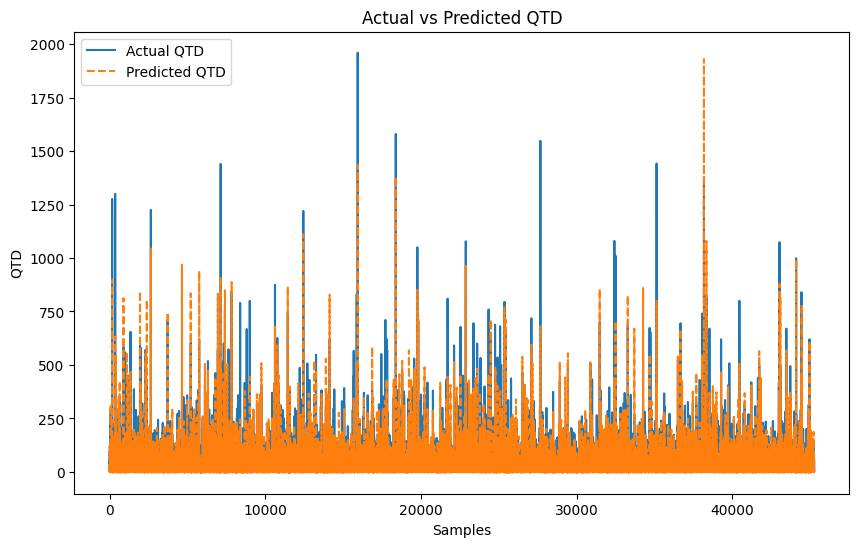

In [44]:
# Plot predictions vs actuals
plt.figure(figsize=(10, 6))
plt.plot(y_test_inv, label='Actual QTD')
plt.plot(y_pred, label='Predicted QTD', linestyle='dashed')
plt.xlabel('Samples')
plt.ylabel('QTD')
plt.title('Actual vs Predicted QTD')
plt.legend()
plt.show()


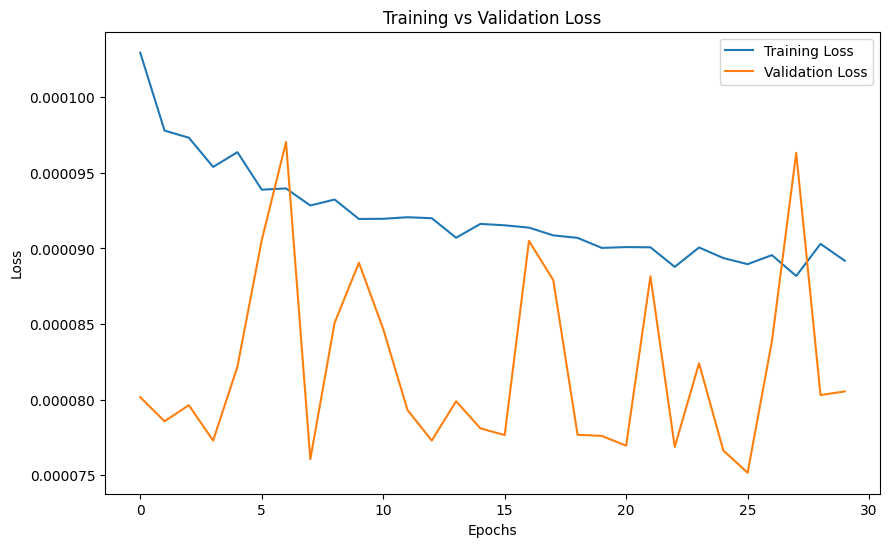

In [45]:
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training vs Validation Loss')
plt.legend()
plt.show()

In [46]:
# Exemplo de valores únicos para Produto e Unidade na sua base de dados

# Mostrar os primeiros valores únicos de Produto e Unidade
produtos_exemplo = df['Produto'].unique()[:10]  # Pegando os 10 primeiros produtos
unidades_exemplo = df['Unidade'].unique()[:10]  # Pegando as 10 primeiras unidades

print("Exemplos de Produtos:", produtos_exemplo)
print("Exemplos de Unidades:", unidades_exemplo)

Exemplos de Produtos: [117577 105275 108952 116153 117080 118877 119087 102416 110489 103153]
Exemplos de Unidades: ['LM' 'WSP' 'MB' 'WSUL' 'WCO' 'WNE' 'WMG']


In [47]:
# 1. Exemplo de vendas dos últimos 6 meses para o produto (QTD)
sales_last_6_months = [27, 47, 76, 82, 31, 35]  # Substitua pelos dados reais

# 2. Codificação do produto e unidade
encoded_prod = le_produto.transform(['117577'])[0]  # Substitua pelo nome real do produto
encoded_und = le_unidade.transform(['LM'])[0]    # Substitua pela unidade real

# 3. Normalizar os dados
sales_last_6_months_scaled = scaler_X.transform(np.array(sales_last_6_months).reshape(1, 6))

# 4. Fazer a previsão
sample_pred_scaled = model.predict([sales_last_6_months_scaled.reshape(1, 6, 1), np.array([encoded_prod]), np.array([encoded_und])])
sample_pred = scaler_y.inverse_transform(sample_pred_scaled)

# 5. Exibir a previsão
print(f"Predição de QTD para o próximo mês: {sample_pred[0][0]}")
#Real Result = 70

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Predição de QTD para o próximo mês: 43.87317657470703


In [48]:
# 1. Exemplo de vendas dos últimos 6 meses para o produto (QTD)
sales_last_6_months = [32, 71, 33, 46, 45, 40]  # Substitua pelos dados reais

# 2. Codificação do produto e unidade
encoded_prod = le_produto.transform(['108952'])[0]  # Substitua pelo nome real do produto
encoded_und = le_unidade.transform(['LM'])[0]    # Substitua pela unidade real

# 3. Normalizar os dados
sales_last_6_months_scaled = scaler_X.transform(np.array(sales_last_6_months).reshape(1, 6))

# 4. Fazer a previsão
sample_pred_scaled = model.predict([sales_last_6_months_scaled.reshape(1, 6, 1), np.array([encoded_prod]), np.array([encoded_und])])
sample_pred = scaler_y.inverse_transform(sample_pred_scaled)

# 5. Exibir a previsão
print(f"Predição de QTD para o próximo mês: {sample_pred[0][0]}")
#Real Result = 39

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Predição de QTD para o próximo mês: 36.11101150512695
